In [37]:
# Windhoek Monthly Weather Averages (2019–2024)
# --
!pip install meteostat pandas matplotlib tzdata

In [38]:

# This notebook-style script pulls historical monthly averages for Windhoek
# using the free Meteostat Python library (no API key required).
#
# What you get per month:
# - tavg: Average temperature (°C)
# - tmin / tmax: Mean daily min & max over the month (°C)
# - prcp: Total precipitation (mm)
# - tsun: Total bright sunshine duration (hours)
# - pres: Mean sea-level pressure (hPa)
# - wspd / wpgt: Mean & max wind speed (km/h)
# - Others if available: wdir (°), snow (mm)
#
# Notes:
# - "Forecast" doesn’t exist for past years; we’re downloading observed data.
# - Meteostat returns a tidy monthly DataFrame indexed by month.
# - If a month’s tavg is missing, we’ll compute it as (tmin + tmax)/2 when possible.
# - You can easily extend this to other metrics or export to CSV/Excel.

# 1) Install dependencies (uncomment these in a notebook cell if needed)
# !pip install meteostat pandas matplotlib tzdata

from datetime import datetime
import pandas as pd
import numpy as np
from meteostat import Point, Monthly
import matplotlib.pyplot as plt


In [39]:
# 2) Define location: Windhoek, Namibia
# Coords: approx city center; altitude helps Meteostat pick the right station blend
WINDHOEK = Point(-22.5609, 17.0658, 1650)



In [40]:
# 3) Set date range (inclusive)
START = datetime(2019, 1, 1)
END   = datetime(2024, 12, 31)


In [41]:
# 4) Fetch monthly data
monthly = Monthly(WINDHOEK, START, END)
# .normalize(True) would normalize by day count; we want standard results, so keep default


In [47]:
df = monthly.fetch()

In [49]:
# 5) Clean up & fill helpful fields
# If tavg missing but tmin/tmax present, estimate tavg
missing_tavg = df['tavg'].isna() & df['tmin'].notna() & df['tmax'].notna()
df.loc[missing_tavg, 'tavg'] = (df.loc[missing_tavg, 'tmin'] + df.loc[missing_tavg, 'tmax']) / 2


In [51]:

# Add explicit year/month columns for convenience
out = df.copy()
out['year'] = out.index.year
out['month'] = out.index.month


In [53]:
# Reorder columns
cols_order = [
    'year','month','tavg','tmin','tmax','prcp','tsun','pres','wspd','wpgt','wdir','snow'
]
existing = [c for c in cols_order if c in out.columns]
out = out[existing]


In [55]:
# 6) Display quick preview
print(out.head())
print("\nColumns available:", list(out.columns))


            year  month  tavg  tmin  tmax  prcp  tsun    pres  wspd
time                                                               
2019-01-01  2019      1  26.4  18.6  35.8  10.0  <NA>  1012.5  <NA>
2019-02-01  2019      2  25.9  19.2  33.9   7.0  <NA>  1013.4  <NA>
2019-03-01  2019      3  25.3  19.3  33.7  34.0  <NA>  1014.4  <NA>
2019-04-01  2019      4  21.7  16.1  28.9  <NA>  <NA>  1015.9  <NA>
2019-05-01  2019      5  20.6  13.9  27.9   2.0  <NA>  1018.8  <NA>

Columns available: ['year', 'month', 'tavg', 'tmin', 'tmax', 'prcp', 'tsun', 'pres', 'wspd']


In [57]:

# 7) Save to files
out.to_csv('windhoek_monthly_2019_2024_meteostat.csv', index=True)
out.to_excel('windhoek_monthly_2019_2024_meteostat.xlsx', index=True)
output_path = r"C:/Users/PC/Documents/Water datasets/windhoek_monthly_2019_2024_meteostat.xlsx"

In [59]:
# Coerce to float, then fill missing with 0
prcp = pd.to_numeric(out['prcp'], errors='coerce')
prcp_filled = prcp.fillna(0)

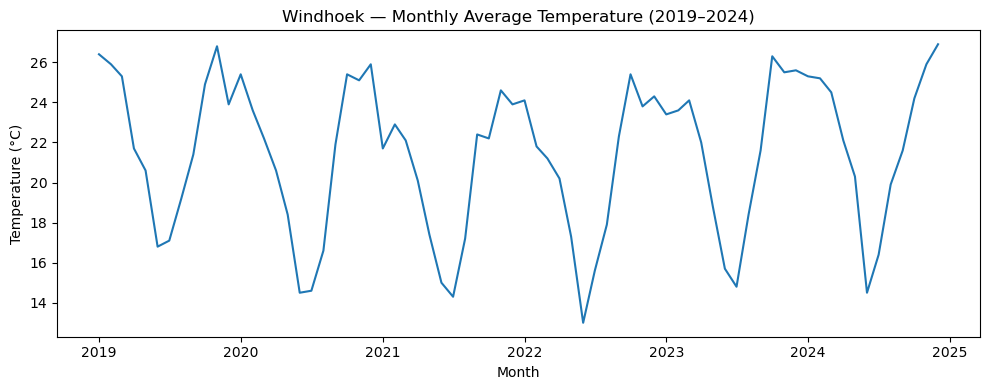

In [61]:
# 8) Quick plots (optional)
# Average temperature over time
plt.figure(figsize=(10,4))
plt.plot(out.index, out['tavg'])
plt.title('Windhoek — Monthly Average Temperature (2019–2024)')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()


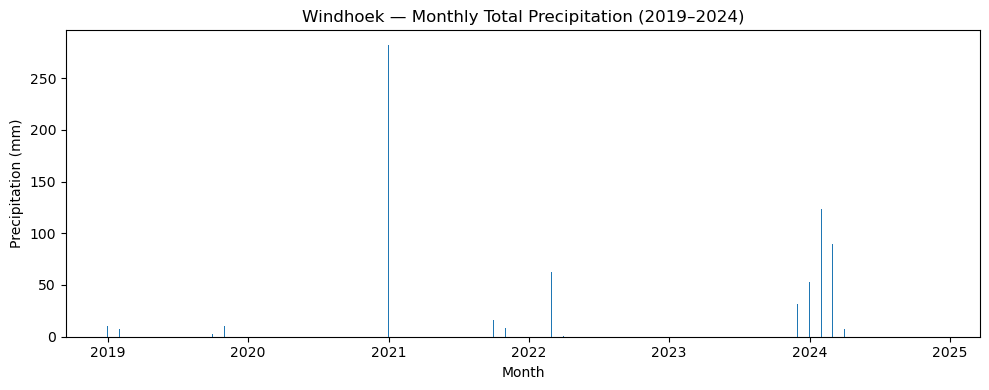

In [65]:
# Total precipitation by month (as a bar chart)
plt.figure(figsize=(10,4))
bars = plt.bar(out.index, prcp_filled)
plt.title('Windhoek — Monthly Total Precipitation (2019–2024)')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.tight_layout()


In [67]:
# 9) Climatology view (what a typical month looks like across years)
# Example: average of each calendar month over 2019–2024
clim = out.groupby('month').agg({
    'tavg':'mean',
    'tmin':'mean',
    'tmax':'mean',
    'prcp':'mean',
    'tsun':'mean'
}).reset_index()


In [69]:
print("\nMonthly climatology (mean across 2019–2024):\n", clim)



Monthly climatology (mean across 2019–2024):
     month       tavg       tmin       tmax       prcp  tsun
0       1  24.383333  18.166667      32.65       96.5  <NA>
1       2  23.833333  17.933333  31.566667       82.4  <NA>
2       3  23.233333  16.883333      31.25  42.166667  <NA>
3       4  21.116667  14.666667  28.816667       28.0  <NA>
4       5       18.8  12.316667      26.35        6.4  <NA>
5       6  14.916667   8.066667  23.033333        0.0  <NA>
6       7  15.466667   8.283333      23.95   0.083333  <NA>
7       8       18.2  10.883333  26.666667        0.2  <NA>
8       9  21.866667       14.2  30.066667        0.5  <NA>
9      10  24.733333  17.116667      32.85  13.666667  <NA>
10     11  25.283333  18.016667  33.183333      10.75  <NA>
11     12  25.083333      18.05      32.85       64.4  <NA>


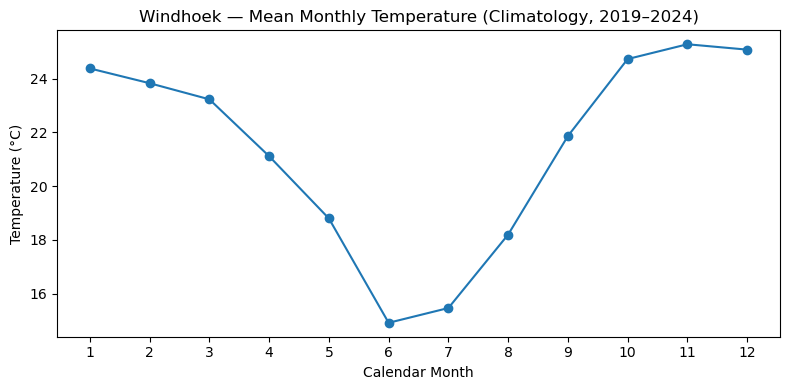

In [71]:
plt.figure(figsize=(8,4))
plt.plot(clim['month'], clim['tavg'], marker='o')
plt.title('Windhoek — Mean Monthly Temperature (Climatology, 2019–2024)')
plt.xlabel('Calendar Month')
plt.ylabel('Temperature (°C)')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()

# 10) (Optional) Convert index to local timezone
# Meteostat monthly data are period-based; timezone conversions matter more for hourly/daily.
# If you later use daily/hourly data, you can localize to Africa/Windhoek like so:
# tz = 'Africa/Windhoek'
# daily = Daily(WINDHOEK, START, END).fetch().tz_localize('UTC').tz_convert(tz)

# That’s it! You can now analyze `out` as needed in your Jupyter notebook.